## IBM comparing methods - kMeans Clustering

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd 
import numpy as np

# NLP packages
import re
import nltk
import string
import enchant
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline   

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.cluster import KMeans

from sklearn.utils import shuffle

In [2]:
df_IBM=pd.read_csv("IBM.csv",encoding = "UTF-8")  #"ISO-8859-1"
#change the order
df_IBM =df_IBM[[ 'Employee ID',
                 'Date',
                 'Location',
                 'Employee Status',
                 'Employee Position',
                 'Overall Rating',
                 'Work Life Balance',
                 'Company Culture',
                 'Career Opportunity',
                 'Benefit and Compensation',
                 'Senior Management',
                 'Helpful Count',
                 'Evaluation',
                 'Overall Comment',
                 'Pros',
                 'Cons',
                 'Advice']]

df_IBM['Company Name'] = df_IBM.apply(lambda _: 'IBM', axis=1)
#df_IBM["Employee Status"].value_counts() 
#df_IBM["Employee Position"].value_counts() 
#df_IBM["Date"].value_counts() 

In [3]:
# create 2 more columns which is combined review & review length
# combined review
df_IBM['CombineReview'] = df_IBM[df_IBM.columns[-3:]].apply(lambda x: ' '.join(x.astype(str).astype(str)), axis=1)
# review length
df_IBM['review length'] = df_IBM['CombineReview'].apply(len)

## New dataframe: matching the employee ID for splitted Pros comments 

In [5]:
IBM_pro_reviews=df_IBM[['Employee ID','Pros', 'Company Name']]
splitted_pros = pd.DataFrame(IBM_pro_reviews.Pros.str.split(r"\.|\,|\+|\?|\!|\;").tolist(), \
                             index=IBM_pro_reviews['Employee ID']).stack()

splitted_pros = splitted_pros.reset_index()[['Employee ID', 0]] 
splitted_pros.columns = ['Employee ID', 'Pros'] 
cleaned_pros=[item for item in splitted_pros.Pros if len(str(item).split())>=2]
splitted_pros=splitted_pros.loc[splitted_pros['Pros'].isin(cleaned_pros)]

#splitted_pros['Company Name'] = splitted_pros.apply(lambda _: 'IBM', axis=1)
splitted_pros.head()
type(splitted_pros)

,Employee ID,Pros
0,empReview_17651831,The working culture and environment is good here
1,empReview_17651831,Freedom to employees and facility of work fro...
3,empReview_19452793,Good working environment and opportunity to wo...
5,empReview_4852131,Disclaimer: A lot of what I'm writing below of...
6,empReview_4852131,But I found this to be fairly pervasive polic...


pandas.core.frame.DataFrame

In [6]:
pros=["".join(item) for item in splitted_pros.Pros]
pros[0:5]

['The working culture and environment is good here',
 ' Freedom to employees and facility of work from home',
 'Good working environment and opportunity to work different countries',
 "Disclaimer: A lot of what I'm writing below of course depends on the work area and management chain",
 ' But I found this to be fairly pervasive policies in IBM in my 9']

In [7]:
stop_words=stopwords.words('english')
more_stopwords = """etc nan also some just have from it's /via &amp; that they your there this into would can't"""
stop_words += more_stopwords.split()

In [8]:
d = enchant.Dict("en_US")    # english dictionary

def text_cleaning(text):
    text=text.lower()
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    tokens=nltk.word_tokenize(nopunc)
    tokens=[token for token in tokens if token.isalpha()]
    tokens=[token for token in tokens if token not in stop_words]
    tagged_tokens= nltk.pos_tag(tokens)
        
    words=filter(lambda x: d.check(x), tokens)
    clean_word=[word for word in words if word not in stop_words]
    return clean_word, tagged_tokens 

def taggedwords(review_list):
    packed_words=[]
    for review in review_list:     # use target list for analysis here is cons
        packed_words.append(text_cleaning(review))
        
    review_words,tagged_tokens=zip(*packed_words)
    return tagged_tokens

In [9]:
# obtain tagged_tokens in pros & cons
pros_tagged_tokens=taggedwords(pros)

#cons_tagged_tokens=taggedwords(cons)

In [10]:
# obtain lemmatized reviews
wordnet_lemmatizer = WordNetLemmatizer()
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

pros_lemmatized_words=[] 
for idx, doc in enumerate(pros_tagged_tokens):
    pros_lemmatized_words.append([wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for (word, tag) in doc])
len(pros_lemmatized_words)

#cons_lemmatized_words=[] 
#for idx, doc in enumerate(cons_tagged_tokens):
#    cons_lemmatized_words.append([wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for (word, tag) in doc])
#len(cons_lemmatized_words)

90161

In [11]:
pros_lemmatized_text=[" ".join(item) for item in pros_lemmatized_words]

# add the lemmatized pros in data frame 
splitted_pros.loc[:,'lemmatized_pros'] = pros_lemmatized_text
splitted_pros.head()

,Employee ID,Pros,lemmatized_pros
0,empReview_17651831,The working culture and environment is good here,working culture environment good
1,empReview_17651831,Freedom to employees and facility of work fro...,freedom employee facility work home
3,empReview_19452793,Good working environment and opportunity to wo...,good work environment opportunity work differe...
5,empReview_4852131,Disclaimer: A lot of what I'm writing below of...,disclaimer lot im write course depend work are...
6,empReview_4852131,But I found this to be fairly pervasive polic...,find fairly pervasive policy ibm


In [203]:
split_lemma_pros=splitted_pros.loc[splitted_pros['lemmatized_pros'].isin([item for item in splitted_pros.lemmatized_pros if len(str(item).split())>=2])]

split_lemma_pros.head()
len(split_lemma_pros)

,Employee ID,Pros,lemmatized_pros
0,empReview_17651831,The working culture and environment is good here,working culture environment good
1,empReview_17651831,Freedom to employees and facility of work fro...,freedom employee facility work home
3,empReview_19452793,Good working environment and opportunity to wo...,good work environment opportunity work differe...
5,empReview_4852131,Disclaimer: A lot of what I'm writing below of...,disclaimer lot im write course depend work are...
6,empReview_4852131,But I found this to be fairly pervasive polic...,find fairly pervasive policy ibm


87294

## 1st round Clustering kmeans

In [13]:
# shuffle the data before clustering
pros_lemmatized_text=shuffle(split_lemma_pros)  # dataframe shuffle for later clustering
pros_lemmatized_text.head()

,Employee ID,Pros,lemmatized_pros
74929,empReview_12368119,best opportunity to learn,best opportunity learn
107576,empReview_1219674,Very Open workcultureNo racial/gender bias,open workcultureno racialgender bias
46057,empReview_911206,Lots of opportunitiesLong-term career prospect...,lot opportunitieslongterm career prospectschal...
16608,empReview_11198971,Part-time work available,parttime work available
89267,empReview_7071794,flexible working hours,flexible working hour


In [14]:
tfidf_vect = TfidfVectorizer(stop_words=stop_words,ngram_range=(1,2),min_df=10) 

# generate tfidf matrix for pros & cons
pros_cluster_dtm= tfidf_vect.fit_transform(pros_lemmatized_text.lemmatized_pros)

#cons_cluster_dtm= tfidf_vect.fit_transform(cons_lemmatized_text)

print (pros_cluster_dtm.shape)

(87294, 5615)


In [15]:
# randomly decided the clustering number
pros_num_clusters=20
pros_km = KMeans(n_clusters=pros_num_clusters, n_init=10).fit(pros_cluster_dtm)
pros_clusters = pros_km.labels_.tolist()

In [16]:
pros_labels = pros_km.labels_
pros_centroids = pros_km.cluster_centers_
pros_sorted_centroids = pros_centroids.argsort()[:, ::-1] 

voc_lookup= tfidf_vect.get_feature_names()

for i in range(pros_num_clusters):
    
    pros_top_words=[voc_lookup[word_index] \
               for word_index in pros_sorted_centroids[i, :25]]
    print("Cluster %d: %s " % (i, "; ".join(pros_top_words)))

Cluster 0: learn; technology; new; lot; learn lot; new technology; learn new; great; thing; place learn; place; lot learn; edge; edge technology; work; great technology; exposure; new thing; good; late; experience; great place; skill; opportunity learn; late technology 
Cluster 1: work; great; team; lot; project; job; place; management; time; pay; nice; career; experience; colleague; manager; many; well; salary; training; client; coworkers; best; challenge; office; business 
Cluster 2: flexibility; flexibility work; work; home; work home; work flexibility; lot flexibility; hour; great flexibility; work hour; great; lot; time; location; good; good flexibility; schedule; time flexibility; work location; flexibility hour; flexibility good; timing; job; office; hour flexibility 
Cluster 3: ibm; work ibm; work; year; company; best; great; place; ibm great; good; people; many; career; technology; one; experience; place work; opportunity; still; provide; resume; within ibm; well; ibm good; wi

### Conclusion after 1st clustering 

- not clear clutsers: 1,3,4,10,12: 
- 0: technology
- 2/13/18: flexible time/work hour/location
- 5/19: work-life
- 6/7/9: people/team/colleague
- 8: benefit
- 11: opportunity
- 14/17: company/brand name
- 15: culture
- 16: work environment 

## plot 1st clustering distribution

### number of reviews vs cluster name 

In [21]:
# after kmeans' results
test=pd.DataFrame(list(zip(pros_lemmatized_text.lemmatized_pros,\
                           list(pros_labels),\
                           pros_lemmatized_text['Employee ID'])), columns=['pro_text','pro_label','Employee ID']) 

<Container object of 20 artists>

Text(0.5,0,'Clusters')

Text(0,0.5,'# of reviews')

Text(0.5,1,'1st Round clustering results')

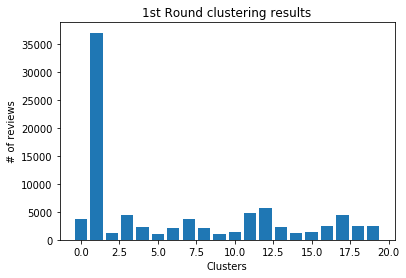

In [33]:
cluster1_distribution=pd.DataFrame(test.groupby(['pro_label'])['pro_label'].count())
cluster1_distribution.index=range(0,20)  
#cluster1_distribution
plt.bar(cluster1_distribution.index,cluster1_distribution.pro_label)
plt.xlabel('Clusters')
plt.ylabel('# of reviews')
plt.title('1st Round clustering results') 

### after 1st clustering identified groups

1. group them and merge them to different topics
2. identified reviews in this step: 36416

## 1st round re-clustering the unsplitted cluster (s) 
1. un-splitted reviews: 50878

In [171]:
# select unclear topics and recombine into new data frame
# drop the pro-label for later to create new labels
re_cluster1=test.loc[test['pro_label'].isin([1,3,4,10,12])]
len(re_cluster1)

re_cluster1=re_cluster1.drop(columns=['pro_label'])
re_cluster1=shuffle(re_cluster1)
re_cluster1.head()

50878

,pro_text,Employee ID
22083,scale company provide ability forefront servic...,empReview_41939
48337,interesting work,empReview_17606596
43029,reconnaissance internationale et puissance de feu,empReview_786676
14158,work top u client,empReview_12222771
75267,quality work,empReview_1560623


In [172]:
# new TfidfVectorizer setting
tfidf_vect_recluster1 = TfidfVectorizer(stop_words=stop_words,ngram_range=(1,2),min_df=5) 
re_cluster1_pro_dtm= tfidf_vect_recluster1.fit_transform(list(re_cluster1.pro_text))
print (re_cluster1_pro_dtm.shape)

re_num_clusters1=12
re_cluster1_km = KMeans(n_clusters=re_num_clusters1, n_init=10).fit(re_cluster1_pro_dtm)
pro_re_clusters1 = re_cluster1_km.labels_.tolist()

recluster1_pros_labels = re_cluster1_km.labels_
recluster1_pros_centroids = re_cluster1_km.cluster_centers_
recluster1_pros_sorted_centroids = recluster1_pros_centroids.argsort()[:, ::-1] 

voc_lookup= tfidf_vect_recluster1.get_feature_names()
for i in range(re_num_clusters1):
    
    recluster1_pros_top_words=[voc_lookup[word_index] \
               for word_index in recluster1_pros_sorted_centroids[i, :20]]
    print("re-Cluster %d: %s " % (i, "; ".join(recluster1_pros_top_words)))

(50878, 7952)
re-Cluster 0: salary; good salary; good; competitive; competitive salary; decent salary; decent; salary good; average; start salary; salary competitive; start; great salary; average salary; high salary; great; high; ok; fair; benefit 
re-Cluster 1: lot; job; management; career; team; project; many; nice; manager; training; well; colleague; experience; process; people; office; resource; client; year; like 
re-Cluster 2: get; get work; work; opportunity; lot; people; experience; job; good; project; get job; get good; technology; ibm; chance; easy get; easy; learn; get experience; opportunity get 
re-Cluster 3: work; interesting; project; life; team; home; interesting project; hard; interesting work; challenge; remote; work life; remotely; people; balance; work remotely; work home; pressure; work pressure; team work 
re-Cluster 4: place; place work; good place; work; great place; good; great; place start; nice place; place learn; start; best place; learn; nice; start career;

### Conclusion after 1st round re-clustering  (12 topics)
-- re-Cluster topics 
- 1,2,9: not clear
- 0,5: salary
- 3,10: flexibility
- 4, 7: company brand/global
- 6: career path/growth
- 8: culture
- 11: people/team/colleague

50878

<Container object of 12 artists>

Text(0.5,0,'Clusters')

Text(0,0.5,'# of reviews')

Text(0.5,1,'1st Round re-clustering results')

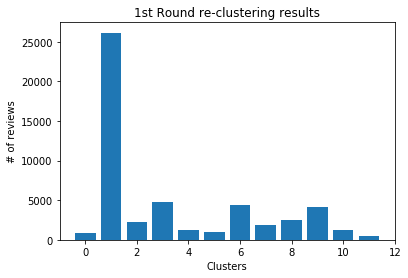

In [199]:
# after kmeans' reclustering 
test1=pd.DataFrame(list(zip(re_cluster1.pro_text,list(recluster1_pros_labels),re_cluster1['Employee ID'])), columns=['pro_text','pro_label','Employee ID'])
len(test1)
recluster1_distribution=pd.DataFrame(test1.groupby(['pro_label'])['pro_label'].count())
recluster1_distribution.index=range(0,12)  

#cluster1_distribution
plt.bar(recluster1_distribution.index,recluster1_distribution.pro_label)
plt.xlabel('Clusters')
plt.ylabel('# of reviews')
plt.title('1st Round re-clustering results') 

## 2nd time reclustering need change min-df

In [209]:
# after kmeans' reclustering all un-clear topics
re_cluster2=test1.loc[test1['pro_label'].isin(['1','2','9'])]
len(re_cluster2)
re_cluster2=shuffle(re_cluster2)

32472

In [210]:
tfidf_vect_recluster2 = TfidfVectorizer(stop_words=stop_words,ngram_range=(1,2),min_df=5) 
re_cluster2_pro_dtm= tfidf_vect_recluster2.fit_transform(list(re_cluster2.pro_text))
print (re_cluster2_pro_dtm.shape)

(32472, 5536)


In [211]:
re_num_clusters2=10
re_cluster2_km = KMeans(n_clusters=re_num_clusters2, n_init=10).fit(re_cluster2_pro_dtm)
pro_re_clusters2 = re_cluster2_km.labels_.tolist()

recluster2_pros_labels = re_cluster2_km.labels_
recluster2_pros_centroids = re_cluster2_km.cluster_centers_
recluster2_pros_sorted_centroids = recluster2_pros_centroids.argsort()[:, ::-1] 

voc_lookup= tfidf_vect_recluster2.get_feature_names()

for i in range(re_num_clusters2):
    
    recluster2_pros_top_words=[voc_lookup[word_index] \
               for word_index in recluster2_pros_sorted_centroids[i, :20]]
    print("reCluster2 %d: %s " % (i, "; ".join(recluster2_pros_top_words)))

reCluster2 0: process; colleague; friendly; professional; orient; process orient; friendly colleague; helpful; smart; smart colleague; well; atmosphere; friendly atmosphere; development; professional growth; professional development; helpful colleague; growth; supportive; process driven 
reCluster2 1: team; member; team member; global team; friendly; friendly team; global; excellent team; supportive; helpful; excellent; support; many team; team mate; mate; helpful team; many; strong; part; manager 
reCluster2 2: management; senior management; supportive; senior; project management; support; management team; supportive management; project; excellent; upper; micro; micro management; upper management; team; strong; level; excellent management; professional; support management 
reCluster2 3: career; project; many; manager; training; experience; client; well; year; office; like; one; global; people; industry; skill; big; best; growth; resource 
reCluster2 4: nice; nice colleague; colleague;

### Conclusion after 2nd round re-clustering  (10 topics)
-- re-Cluster topics 
- 0,3, is not clear, multilabel--> put as multi
- 1: people
- 2: management
- 4: work environment
- 5: job security
- 6: company brand
- 7: work/project
- 8: career path/growth
- 9: opportunity

<Container object of 10 artists>

Text(0.5,0,'Clusters')

Text(0,0.5,'# of reviews')

Text(0.5,1,'2nd Round re-clustering results')

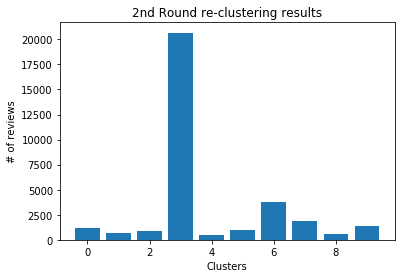

In [212]:
# after kmeans' 2nd reclustering 
test2=pd.DataFrame(list(zip(re_cluster2.pro_text,list(recluster2_pros_labels),re_cluster2['Employee ID'])), columns=['pro_text','pro_label','Employee ID'])

recluster2_distribution=pd.DataFrame(test2.groupby(['pro_label'])['pro_label'].count())
recluster2_distribution.index=range(0,10)  

#cluster1_distribution
plt.bar(recluster2_distribution.index,recluster2_distribution.pro_label)
plt.xlabel('Clusters')
plt.ylabel('# of reviews')
plt.title('2nd Round re-clustering results') 

## clean the topics from the clustering results for later visulization

### 1st round
- not clear clutsers: 1,3,4,10,12: 
- 0: technology
- 2/13/18: flexible time/work hour/location
- 5/19: work-life
- 6/7/9: people/team/colleague
- 8: benefit
- 11: opportunity
- 14/17: company/brand name
- 15: culture
- 16: work enviroment 


### Conclusion after 1st round re-clustering  (12 topics)
-- re-Cluster topics 
- 1,2,9: not clear
- 0,5: salary
- 3,10: flexibility
- 4, 7: company brand/global
- 6: career path/growth
- 8: culture
- 11: people/team/colleague


### Conclusion after 2nd round re-clustering  (10 topics)
-- re-Cluster topics 
- 0,3, is not clear, multilabel--> put as culture
- 1: people
- 2: management
- 4: work environment
- 5: job security
- 6: company brand
- 7: work/project
- 8: career path/growth
- 9: opportunity

In [213]:
topics_1stclustering=test.loc[test['pro_label'].isin([0,2,13,18,5,19,6,7,9,8,11,14,17,15,16])]

topics_1stclustering['pro_cluster'] = topics_1stclustering['pro_label'].\
replace([0,2,13,18,5,19,6,7,9,8,11,14,17,15,16],\
        ['technology',\
         'flexiblility','flexiblility','flexiblility',\
         'work-life','work-life',\
         'people','people','people',\
         'benefit',\
         'opportunity',\
         'company brand', 'company brand',\
        'culture',\
        'work environment'])

topics_1stclustering=topics_1stclustering.drop(columns=['pro_label'])
topics_1stclustering.head()
len(topics_1stclustering)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,pro_text,Employee ID,pro_cluster
0,best opportunity learn,empReview_12368119,opportunity
2,lot opportunitieslongterm career prospectschal...,empReview_911206,people
4,flexible working hour,empReview_7071794,flexiblility
10,great work environment,empReview_8250251,work environment
11,work home,empReview_11066335,flexiblility


36416

In [231]:


# after 1st re-clustering
reclustering1=test1.loc[test1['pro_label'].isin([0,5,3,10,4,7,6,8,11])]
len(re_cluster_clear)

#reclustering1=re_cluster1.loc[re_cluster1['pro_label'].isin([0,5,3,10,4,7,6,8,11])]

reclustering1['pro_cluster'] = reclustering1['pro_label'].\
replace([0,5,3,10,4,7,6,8,11],\
        ['salary','salary',\
         'flexiblility','flexiblility',\
         'company brand','company brand',\
         'career growth','culture','people'])

reclustering1=reclustering1.drop(columns=['pro_label'])

reclustering1.head()

16909

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,pro_text,Employee ID,pro_cluster
1,interesting work,empReview_17606596,flexiblility
3,work top u client,empReview_12222771,flexiblility
4,quality work,empReview_1560623,flexiblility
7,learn opportunityinternational backgroundcapab...,empReview_1852835,company brand
10,good train new job,empReview_9951212,career growth


In [232]:

# after 1st re-clustering
reclustering2=test2
len(reclustering2)

#reclustering2=re_cluster2.loc[re_cluster2['pro_label'].isin([0,3,5,7,8,9])]
reclustering2['pro_cluster'] = reclustering2['pro_label'].\
replace([0,1,2,3,4,5,6,7,8,9],\
        ['unsplit','people','management','unsplit','work environment','job security','company brand',\
         'work/project','career growth','opportunity'])

reclustering2=reclustering2.drop(columns=['pro_label'])
reclustering2[0:15]

32472

,pro_text,Employee ID,pro_cluster
0,unlimited wfh sick leaf,empReview_10060883,unsplit
1,job security,empReview_3368422,job security
2,fast pace,empReview_6538144,unsplit
3,limited risk loose job,empReview_3275385,job security
4,ibm resume always bonus point,empReview_951560,company brand
5,ibms policy management flexible come work remo...,empReview_9437441,unsplit
6,approachable friendly senior management team,empReview_2599005,management
7,much proud seat,empReview_2265781,unsplit
8,constant innovation,empReview_7871313,unsplit
9,still lot smart regional people try something,empReview_10443993,opportunity


In [234]:
IBM_row_merged_pros = pd.concat([topics_1stclustering,reclustering1, reclustering2], ignore_index=True)
len(IBM_row_merged_pros)
IBM_row_merged_pros.to_csv('Pros_IBM_3_clustering.csv')

87294

In [26]:
len(df_IBM)
len(split_lemma_pros)

36312

87294

In [78]:
len(topics_1stclustering)
len(re_cluster1)

36416

50878

In [ ]:
# label_reviews=df_IBM.sample(n=100, frac=None, replace=False, weights=None, random_state=None, axis=None)
# label_cons_sentences=["".join(item) for item in df_IBM.Cons]
# label_pros_sentences=["".join(item) for item in df_IBM.Pros]

# label_pros=[]
# for line in label_pros_sentences:
#     label_pros.append(re.split(r"\.|\,|\+|\?|\!|\;",line))
# pros=sum(label_pros, [])
# pros=[item for item in pros if item != '']
# pros=["".join(item) for item in pros if len(str(item).split())>=2]

# label_cons=[]
# for line in label_cons_sentences:
#    label_cons.append(re.split(r"\.|\,|\+|\?|\!|\;",line))
# cons=sum(label_cons, [])
#cons=[item for item in cons if item != '']
# cons=["".join(item) for item in cons if len(str(item).split())>=2]